In [14]:
#conda create --name ML_project_2023 scikit-learn netCDF4 tqdm numpy matplotlib cartopy rasterio pandas
#conda activate ML_project_2023
#conda config --add channels conda-forge
#conda install jupyterlab

In [1]:
import numpy as np
import pandas as pd
import netCDF4 as n4
import sys
import os
import matplotlib
import cartopy
from tqdm import tqdm
import rasterio

In [10]:
module_FP  = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive/python_modules'
nc_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive/GIST/0.Lectures/2023_Fall/project'

#add hydroAI module to the system path
sys.path.append(module_FP)

from hydroAI import Plot
from hydroAI import Data

#option
#pip install git+https://github.com/Hyunglok-Kim/HydroAI.git
#git clone https://github.com/Hyunglok-Kim/HydroAI.git
#cd HydroAI
#pip install .

dict_keys(['lat', 'lon', 'time', 'SM'])
Shape of SM: (24, 24, 1096)


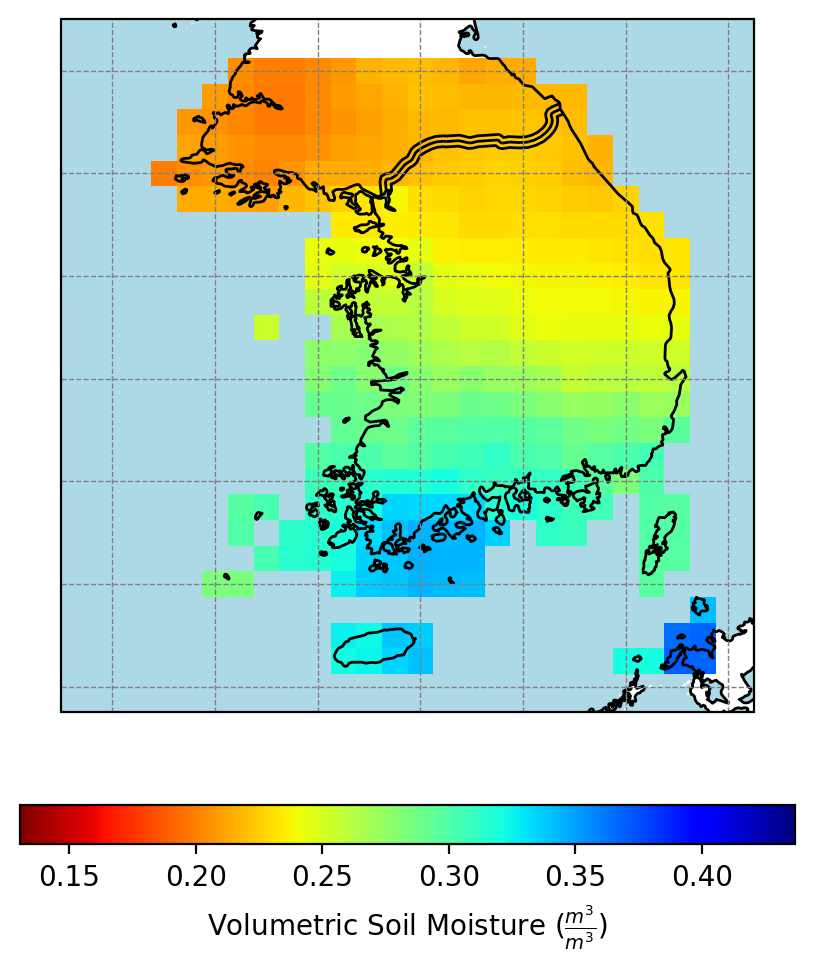

In [32]:
# Load the 25-km soil moisture (SM) data from the SM_data.nc file
ds = n4.Dataset(os.path.join(nc_FP, 'SM_data.nc'), 'r')

# Print out the variables you have
print(ds.variables.keys())

# Access variables
SM_lat = ds.variables['lat'][:]
SM_lon = ds.variables['lon'][:]
times = ds.variables['time'][:]
SM = ds.variables['SM'][:]

# Print the shape of the SM variable to confirm it's what you expect
print("Shape of SM:", SM.shape)

# If you want to convert the time variable to actual dates, you use num2date
dates = n4.num2date(times, ds.variables['time'].units, ds.variables['time'].calendar)

# Check the spatial pattern of the data
Plot.plot_regional_map(SM_lon, SM_lat, SM[:,:,120], r'Volumetric Soil Moisture ($\frac{m^3}{m^3}$)', np.nanmin(SM), np.nanmax(SM), padding=0.5, cmap='jet_r')

# Close the dataset when done
ds.close()

dict_keys(['lat', 'lon', 'time', 'Qh_tavg'])
Shape of X_1km: (601, 601, 1096)


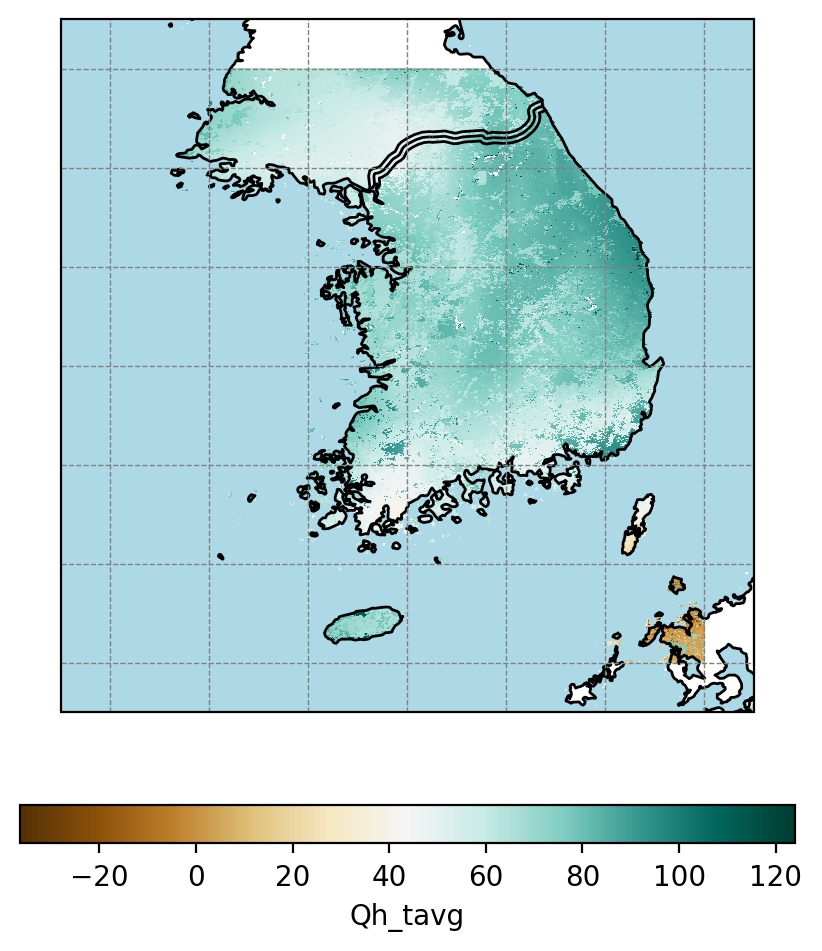

In [33]:
# Load any of 1-km predictor data (check the nc files)

variable_name_1km = 'Qh_tavg'
ds = n4.Dataset(os.path.join(nc_FP, variable_name_1km+'.nc'), 'r')
# Print out the variables you have
print(ds.variables.keys())

# Access variables
lat_1km = ds.variables['lat'][:]
lon_1km = ds.variables['lon'][:]
times = ds.variables['time'][:]
X1_1km = ds.variables[variable_name_1km][:]

# Print the shape of the SM variable to confirm it's what you expect
print("Shape of X_1km:", X1_1km.shape)

# If you want to convert the time variable to actual dates, you use num2date
dates = n4.num2date(times, ds.variables['time'].units, ds.variables['time'].calendar)

t_X1_1km = X1_1km[:,:, 100]
# Check the spatial pattern of the data
Plot.plot_regional_map(lon_1km, lat_1km, t_X1_1km, variable_name_1km, np.nanmin(t_X1_1km), np.nanmax(t_X1_1km), padding=0.5, cmap='BrBG')

# Close the dataset when done
ds.close()

(<Figure size 2000x1200 with 2 Axes>, <GeoAxes: >)

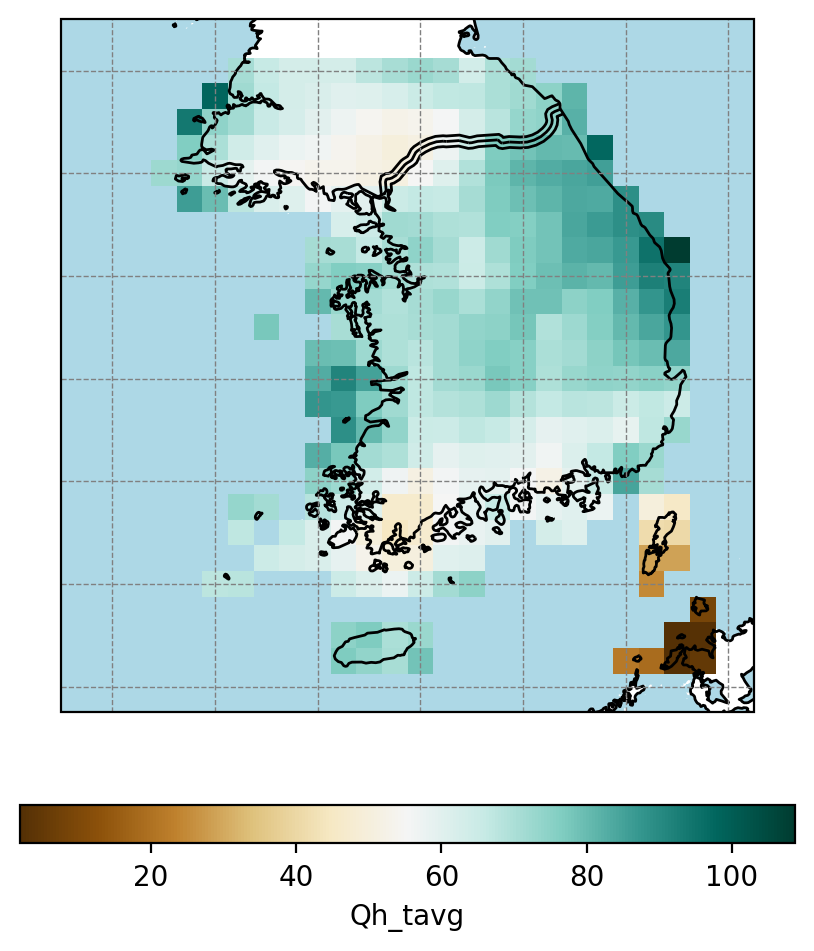

In [25]:
# up-scale the 1-km predictor data to 25-km
t_X1_25km = Data.Resampling(SM_lat.data, SM_lon.data, lat_1km.data, lon_1km.data, X1_1km[:,:,100], 'nearest', 'mean', 1)

# Check the spatial pattern of the data
Plot.plot_regional_map(SM_lon.data, SM_lat.data, t_X1_25km, variable_name_1km, np.nanmin(t_X1_25km), np.nanmax(t_X1_25km), padding=0.5, cmap='BrBG')

In [26]:
n = SM.shape[2]
X1_25km = np.zeros((24,24,n))

for i in tqdm(range(n), desc="Processing"):
    
    t_X1_25km =  Data.Resampling(SM_lat.data, SM_lon.data, lat_1km.data, lon_1km.data, X1_1km[:,:,i], 'nearest', 'mean', 1)
    X1_25km[:, :, i] = (t_X1_25km)

Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1096/1096 [00:15<00:00, 70.68it/s]


In [27]:
# Example code with RF model
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Mean Squared Error: 0.0015875076426385825


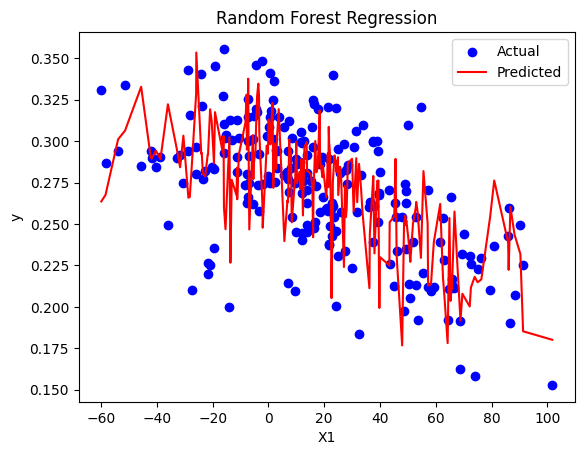

In [28]:
# Extract a pixel's data
y = SM[4, 10, :].data
X1 = X1_25km[4, 10, :]

# Reshape your X1 data to a 2D array with one column.
X1_2d = X1.reshape(-1, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X1_2d, y, test_size=0.2, random_state=42)

# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot the results
# For visualization, we sort the testing data (this is just for making the plot look nicer)
sort_idx = np.argsort(X_test.squeeze())
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test[sort_idx], y_pred[sort_idx], color='red', label='Predicted')
plt.title('Random Forest Regression')
plt.xlabel('X1')
plt.ylabel('y')
plt.legend()
plt.show()